In [130]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from scipy.optimize import curve_fit
import skrf as rf
import scqubits as scq

# 1. Vector Fit Model
Qubit-qubit system with coupler modeled as harmonic mode

### 1.1 Import Admittance Data

In [220]:
admittance_filename_7_4 = '8Q_capacitive_1_GHz_qq_y_7_4.txt'
# admittance_filename_7_4 = '8Q_capacitive_qcq_y_7_4.txt'

number_of_ports = 2

admittance_filename = admittance_filename_7_4

In [221]:
admittance_directory = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_device_design\vector_fitting_admittance_traces'

y_filepath = os.path.join(admittance_directory, admittance_filename)

frequencies = []
admittances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")

# determine number of data points
counter = 0
with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
y_matrix = np.empty((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(y_filepath, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                index_1, index_2 = matrix_element_order[j]
                
                y_matrix[i-1, index_1, index_2] = 1j*float(value)
                
                if index_1 != index_2:
                    y_matrix[i-1, index_2, index_1] = 1j*float(value)
            
        i += 1
        
frequencies = np.array(frequencies)


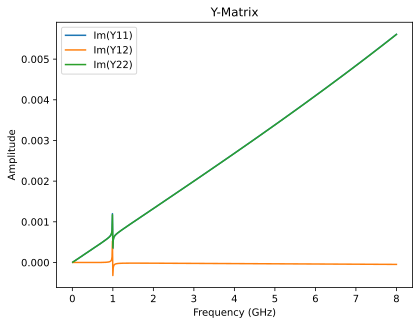

In [222]:
# plot admittances

for i in range(number_of_ports):
    for j in range(i, number_of_ports):
        plt.plot(frequencies, np.imag(y_matrix[:, i, j]), label=f'Im(Y{i+1}{j+1})')

plt.xlabel('Frequency (GHz)')
plt.ylabel('Amplitude')

plt.legend()

plt.title('Y-Matrix')

plt.show()

### 1.2 Fit Circuit Model

In [223]:
frequencies_Hz = frequencies * 1e9
network = rf.Network(frequency=frequencies_Hz, y=y_matrix)

In [224]:
vector_fit = rf.VectorFitting(network)

RMS error y11 = 4.7901691371450806e-05
RMS error y12 = 2.992673009872499e-06
RMS error y22 = 4.758708535051266e-05


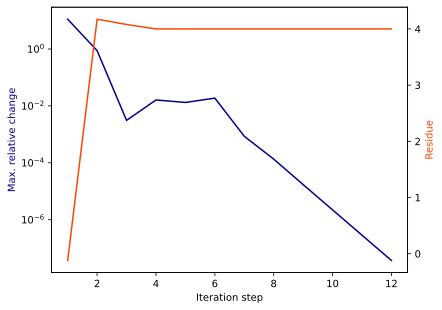

In [225]:
vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=1, parameter_type='y', fit_constant=False, fit_proportional=True)
vector_fit.plot_convergence()

for i in range(number_of_ports):
    for j in range(i, number_of_ports):

        print(f'RMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')


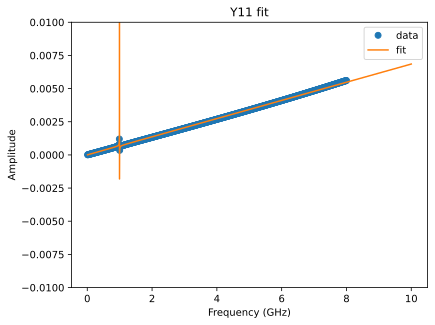

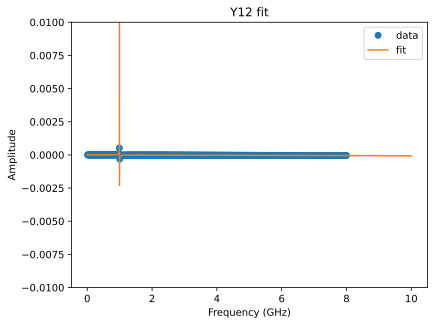

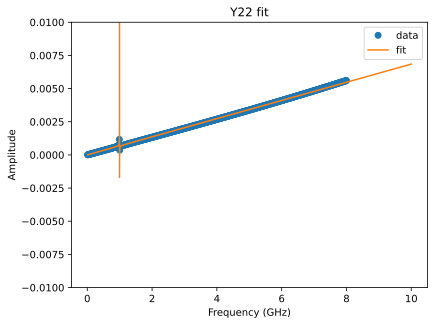

In [226]:
model_frequencies = np.linspace(0.01e9, 10e9, 10000)

for i in range(number_of_ports):
    for j in range(i, number_of_ports):

        model_yij = vector_fit.get_model_response(i, j, model_frequencies)

        plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
        plt.plot(model_frequencies/1e9, np.imag(model_yij), label='fit')

        plt.xlabel('Frequency (GHz)')
        plt.ylabel('Amplitude')

        plt.ylim(-0.01, 0.01)

        plt.legend()

        plt.title(f'Y{i+1}{j+1} fit')
        plt.show()


# # Y12
# plt.plot(frequencies, np.imag(y_matrix[:,0,1]), linestyle='', marker='o', label='data')
# plt.plot(model_frequencies/1e9, np.imag(model_y12), label='fit')

# plt.xlabel('Frequency (GHz)')
# plt.ylabel('Amplitude')

# plt.ylim(-0.01, 0.01)


# plt.legend()

# plt.title('Y12 fit')
# plt.show()

# # Y22
# plt.plot(frequencies, np.imag(y_matrix[:,1,1]), linestyle='', marker='o', label='data')
# plt.plot(model_frequencies/1e9, np.imag(model_y22), label='fit')

# plt.xlabel('Frequency (GHz)')
# plt.ylabel('Amplitude')

# plt.ylim(-0.01, 0.01)


# plt.legend()

# plt.title('Y22 fit')
# plt.show()

# 2. Circuit Parameters

In [227]:
# put residues into NxN matrices where N is number of ports
residues = vector_fit.residues
number_of_poles = len(vector_fit.poles)

print(residues.shape)
print(number_of_poles)

# complex pole
if number_of_poles > 1:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
else:
    residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))
    
print()
print('Residue from complex pole 1')
print(residues_reshaped)

(4, 1)
1

Residue from complex pole 1
[[14115.89945383 13013.41371009]
 [13013.41371009 13446.21808526]]


In [228]:
# perform SVD on each NxN residue matrix

# complex pole

# len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
r_vectors = []
ranks = []

for k in range(number_of_poles):
    
    if number_of_poles > 1:
        residue = residues_reshaped[:,:,k]
    else:
        residue = residues_reshaped
    
    rank = np.linalg.matrix_rank(residue)
    ranks.append(rank)

    U, S, V = np.linalg.svd(residue)
    
    print(S)
    
    r_vectors_k = np.zeros((rank, number_of_ports))
        
    for rank_index in range(rank):
        r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]
        
    r_vectors.append(r_vectors_k)
        
        
max_rank = np.max(ranks)
print(ranks)
for r_vector_k in r_vectors:
    print(r_vector_k.shape)

[26798.77956367   763.33797541]
[2]
(2, 2)


In [229]:
# define circuit parameters for complex pole

# total capacitances C_k
C_k = 20e-15 # F
C_ks = np.array([C_k]*number_of_poles*max_rank) 
C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


# pole frequency omega_k
omega_ks = np.imag(vector_fit.poles) # Hz * 2pi

frequency_ks = omega_ks/2/np.pi # Hz

# print(f'pole 2 frequency: {frequency_2} GHz')
print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


# pole inductance L_k
print(f'\nMode inductances (nH)')
L_ks = np.zeros((number_of_poles, max_rank))
for k in range(number_of_poles):
    L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

    print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


# Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

print('\nCoupling capacitances (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


        print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


# capacitance to ground C_kig = C_k - sum_j [C_ki]_j
C_g_ks = np.zeros((number_of_poles, max_rank))

print('\nPole capacitance to ground (fF)')
for k in range(number_of_poles):
    for rank_index in range(max_rank):
        C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])
        
        print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')


# fit proportional capacitance C_n
C_n = np.reshape(vector_fit.proportional_coeff, (number_of_ports, number_of_ports)) # F
print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')


Pole frequencies: [0.99421074] GHz

Mode inductances (nH)
	pole 0: [1281.307493 1281.307493]

Coupling capacitances (fF)
	pole 0, rank index 0: [-3.7534359  -3.65810068]
	pole 0, rank index 1: [-0.61738572  0.63347566]

Pole capacitance to ground (fF)
	pole 0, rank index 0: 27.411536580806228 fF
	pole 0, rank index 1: 19.98391006434856 fF

proportional coefficients (fF): 
[[ 1.09040690e-28 -1.04563787e-30]
 [-1.04563787e-30  1.08983971e-28]]


In [230]:
# define capacitance matrix

first_term = 0
second_term = 0
for k in range(number_of_poles):
    
    omega = omega_ks[k]
        
    if omega == 0:
        continue
    
    for rank_index in range(max_rank):
        
        r_vector = r_vectors[k][rank_index, :]
        
        first_term += np.outer(r_vector, r_vector)/(omega**2)
        
        second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


cap_matrix = C_n + first_term + second_term

cap_matrix_fF = cap_matrix * 1e15

print('Capacitance Matrix (fF)')
print(cap_matrix_fF)

# analyze capacitance matrix to get capacitances to ground

capacitance_to_grounds = np.sum(cap_matrix, -1)
print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')

Capacitance Matrix (fF)
[[114.13498392  -0.37867049]
 [ -0.37867049 112.69774576]]

Node capacitance to grounds: [113.75631344 112.31907527] fF


# 3. SCQubits

### 3.1 Create Circuit

In [231]:
circuit_parameters = {}

for k in range(number_of_poles):
    for rank_index in range(max_rank):
        circuit_parameters[f'pole_inductance_{k*number_of_poles + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
        circuit_parameters[f'pole_capacitance_ground_{k*number_of_poles + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF
        
        for i in range(number_of_ports):
            circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

for i in range(number_of_ports):
    
    circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF
    
    for j in range(number_of_ports):
        
        if i != j:
            circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF
            
            
            
for key, value in circuit_parameters.items():
    print(f'{key}: {value}')

pole_inductance_0: 1281.3074930006485
pole_capacitance_ground_0: 27.411536580806228
coupling_capacitance_0_0: -3.753435901277461
coupling_capacitance_0_1: -3.6581006795287676
pole_inductance_1: 1281.3074930006485
pole_capacitance_ground_1: 19.98391006434856
coupling_capacitance_1_0: -0.6173857202037711
coupling_capacitance_1_1: 0.6334756558552102
node_capacitance_ground_0: 113.75631343843553
internode_capacitance_01: 0.37867048617572735
node_capacitance_ground_1: 112.31907527015792
internode_capacitance_10: 0.37867048617572757


In [232]:
def create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):   
    circuit_yaml = create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    circuit.configure(np.identity(4))

    circuit.cutoff_n_1 = 9
    circuit.cutoff_n_2 = 9
    circuit.cutoff_ext_3 = 4
    circuit.cutoff_ext_4 = 4
    

    return circuit

In [233]:
def create_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - total_num_poles}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - total_num_poles}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q1, q2, c to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - total_num_poles}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # junctions: [EJ_q1, EJ_q2]
    EJ_q1, EJ_q2 = junction_EJs
    
    # parasitic capacitances: [C_parasitic_q1, C_parasitic_q2]
    C_parasitic_q1, C_parasitic_q2 = parasitic_capacitances
    
    # add junctions and coupler inductor
    
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q1 = {EJ_q1}, {C_parasitic_q1}fF]'
    yaml_str += f'\n- ["JJ", 0, 2, EJ_q2 = {EJ_q2}, {C_parasitic_q2}fF]'
    
    return yaml_str
                    

In [234]:
def sweep_avoided_crossing(EJ_s, circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances, sweep_node_index=0):
    
    EJ_q1, EJ_q2 = junction_EJs
    
    frequencies = []    
    
    for EJ in EJ_s:
    
        junction_EJs_sweep = [EJ_q1, EJ_q2]
        junction_EJs_sweep[sweep_node_index] = EJ
        
        circuit = create_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs_sweep, parasitic_capacitances)


        # get the first two eigenfrequencies and eigenvectors
        evals = circuit.eigenvals(3)

        # print the qubit frequency
        w1 = evals[1]-evals[0]
        w2 = evals[2]-evals[0]
        
#         print(f'(EJ_q1, EJ_q2) = ({EJ_q1}, {EJ})')
#         print(f'frequencies: {efreqs}')
#         print()
        

        frequencies.append([w1, w2])

    return np.array(frequencies)
    
    

In [235]:
# calculate qubit total capacitances

C_tots = []

for i in range(number_of_ports):
    
    C_tot_i = 0

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_tot_i += circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{i}']
    
    C_tot_i += circuit_parameters[f'node_capacitance_ground_{i}']
    
    for j in range(number_of_ports):
        
        if i != j:
            C_tot_i += circuit_parameters[f'internode_capacitance_{i}{j}']
        
    C_tots.append(C_tot_i)
    print(f'node {i} total capacitance: {C_tot_i} fF')
    
# C_q1_tot, C_q2_tot, C_c_tot = C_tots
C_q1_tot, C_q2_tot = C_tots

node 0 total capacitance: 109.76416230313002 fF
node 1 total capacitance: 109.67312073266008 fF


In [236]:
# define junction parameters

h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

### qubit 1 
EJ_q1 = 20 # GHz
EJ_q1_J = EJ_q1 * h # J

L_J1 = (Phi0/(2*np.pi))**2/EJ_q1_J # nH
# L_J = L_J_H * 1e9 # nH

EC_q1 = e*e/(2*C_q1_tot*1e-15)/h/1e6

### qubit 2
EJ_q2 = 20 # GHz
EJ_q2_J = EJ_q2 * h # J

L_J2 = (Phi0/(2*np.pi))**2/EJ_q2_J # nH
# L_J = L_J_H * 1e9 # nH

EC_q2 = e*e/(2*C_q2_tot*1e-15)/h/1e6


C_parasitic_q = 12 # fF


### coupler

EJ_c = 40 # GHz
EJ_c_J = EJ_q1 * h # J

L_c = (Phi0/(2*np.pi))**2/EJ_q1_J # nH
# L_J = L_J_H * 1e9 # nH

EC_c = e*e/(2*C_q1_tot*1e-15)/h/1e6

C_parasitic_c = 12 #fF


print(f'Qubit 1 EJ: {EJ_q1} GHz')
print(f'Qubit 2 EJ: {EJ_q2} GHz')
print(f'Coupler EJ: {EJ_c} GHz')

print()

print(f'Qubit 1 EC: {EC_q1} MHz')
print(f'Qubit 2 EC: {EC_q2} MHz')
print(f'Coupler EC: {EC_c} MHz')

print()

print(f'Qubit 1 junction inductance: {L_J1} nH')
print(f'Qubit 2 junction inductance: {L_J2} nH')
print(f'Coupler junction inductance: {L_c} nH')

print()


frequency_estimate_q1 = (np.sqrt(8*EJ_q1*1e3*EC_q1) - EC_q1)
frequency_estimate_q2 = (np.sqrt(8*EJ_q2*1e3*EC_q2) - EC_q2)
frequency_estimate_c = (np.sqrt(8*EJ_c*1e3*EC_c) - EC_c)

print(f'frequency estimate Q1: {frequency_estimate_q1} MHz')
print(f'frequency estimate Q2: {frequency_estimate_q2} MHz')
print(f'frequency estimate Q2: {frequency_estimate_c} MHz')



Qubit 1 EJ: 20 GHz
Qubit 2 EJ: 20 GHz
Coupler EJ: 40 GHz

Qubit 1 EC: 175.9940440617885 MHz
Qubit 2 EC: 176.14013978750233 MHz
Coupler EC: 175.9940440617885 MHz

Qubit 1 junction inductance: 8.195241245289674 nH
Qubit 2 junction inductance: 8.195241245289674 nH
Coupler junction inductance: 8.195241245289674 nH

frequency estimate Q1: 5130.515830600291 MHz
frequency estimate Q2: 5132.571791180345 MHz
frequency estimate Q2: 7328.544189552077 MHz


In [241]:
junction_EJs = (EJ_q1, EJ_q2)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q)

print(number_of_poles)
print(max_rank)
print(number_of_ports)

circuit = create_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)


 # get the first two eigenfrequencies and eigenvectors
evals = circuit.eigenvals(25)

print((np.array(evals)-evals[0])*1000)

# print the qubit frequency
w1 = evals[1]-evals[0]
w2 = evals[2]-evals[0]

print(w1 * 1000)
print(w2 * 1000)

1
2
2
[   0.          988.79581985  994.05785115  994.38373988 1000.38150567
 1982.85367078 1983.17955989 1984.39431442 1988.30597062 1994.43935698
 1994.76524543 2977.10179153 2978.45216662 2978.77805353 2988.68747551
 3972.70028004 4874.14369995 4917.61517341 5862.97892981 5868.30496766
 5868.49204452 5874.49652461 5910.05433171 5911.67415799 5911.99809884]
988.7958198523777
994.0578511506715


### 3.2 Sweep Avoided Crossing

In [238]:
EJ_start = 19
EJ_stop = 20
num_points = 41

EJ_s = np.linspace(EJ_start, EJ_stop, num_points)

In [213]:
# first sweep each qubit woth the other qubit far away

# Q1
junction_EJs = (EJ_q1, 50)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q)
sweep_node_index = 0

avoided_crossing_frequencies = sweep_avoided_crossing(EJ_s, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances, sweep_node_index=sweep_node_index)
avoided_crossing_frequencies_q1 = avoided_crossing_frequencies[:,0]

avoided_crossing_EJs_q1 = np.copy(EJ_s)


# Q2
junction_EJs = (50, EJ_q2)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q)
sweep_node_index = 1

avoided_crossing_frequencies = sweep_avoided_crossing(EJ_s, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances, sweep_node_index=sweep_node_index)
avoided_crossing_frequencies_q2 = avoided_crossing_frequencies[:,0]
avoided_crossing_EJs_q2 = np.copy(EJ_s)

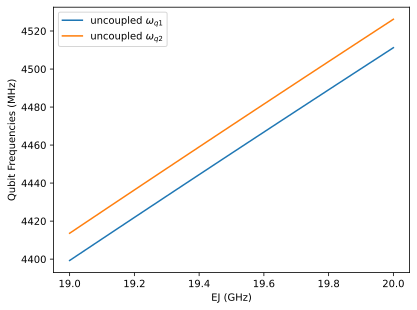

In [214]:
plt.plot(avoided_crossing_EJs_q1, avoided_crossing_frequencies_q1*1000, label='uncoupled $\omega_{q1}$')
plt.plot(avoided_crossing_EJs_q2, avoided_crossing_frequencies_q2*1000, label='uncoupled $\omega_{q2}$')

plt.legend()

plt.xlabel('EJ (GHz)')
plt.ylabel('Qubit Frequencies (MHz)')

plt.show()

In [215]:
# now sweep the avoided crossing between both qubits

junction_EJs = (EJ_q1, EJ_q2)
parasitic_capacitances = (C_parasitic_q, C_parasitic_q)

avoided_crossing_frequencies = sweep_avoided_crossing(EJ_s, circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

avoided_crossing_EJs = np.copy(EJ_s)

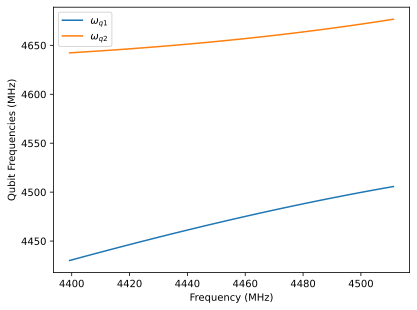

In [216]:
L_EJs = (Phi0/(2*np.pi))**2/avoided_crossing_EJs/h


# swept_frequencies = 1/np.sqrt(L_EJs*C_q1_tot) / (2*np.pi) * 1e6
# swept_frequencies = 1/np.sqrt(L_EJs*C_q2_tot) / (2*np.pi) * 1e6

swept_frequencies = (np.sqrt(8*EJ_s*1e3*EC_q2) - EC_q2)


# plt.plot(avoided_crossing_EJs, model_frequencies[:,0]*1000, label='$\omega_{q1}$')
# plt.plot(avoided_crossing_EJs, model_frequencies[:,1]*1000, label='$\omega_{q2}$')

plt.plot(avoided_crossing_frequencies_q1*1000, avoided_crossing_frequencies[:,0]*1000, label='$\omega_{q1}$')
plt.plot(avoided_crossing_frequencies_q1*1000, avoided_crossing_frequencies[:,1]*1000, label='$\omega_{q2}$')

# plt.plot(avoided_crossing_frequencies_q1*1000, avoided_crossing_frequencies_q1*1000, linestyle='dashed', color='black', label='uncoupled $\omega_{q1}$')
# plt.axhline(avoided_crossing_frequencies_q2[len(EJ_s)//2]*1000, linestyle=':', color='black', label='uncoupled $\omega_{q2}$')

plt.legend()

plt.xlabel('Frequency (MHz)')
plt.ylabel('Qubit Frequencies (MHz)')

plt.show()

In [217]:
def coupling_strength_fit(x, x0, Omega, a, b, c):
    return b*np.sqrt(np.power(a*(x-x0), 2) + np.power(Omega, 2)) + c

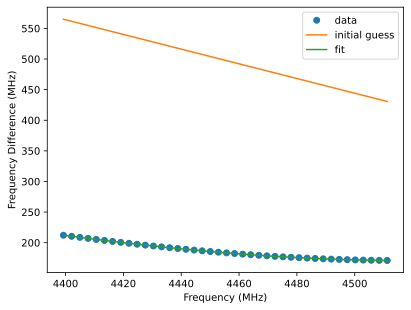

coupling strength: 170.73247362304537 MHz


In [218]:
### plot difference

difference = avoided_crossing_frequencies[:,1] - avoided_crossing_frequencies[:,0]

plt.plot(avoided_crossing_frequencies_q1*1000, difference*1000, marker='o', linestyle='', label='data')

initial_guess = [4.87, 0.5, 60, 0.02, 0]

fit_frequencies = np.linspace(avoided_crossing_frequencies_q1[0], avoided_crossing_frequencies_q1[-1], 1001)

plt.plot(fit_frequencies*1000, coupling_strength_fit(fit_frequencies, *initial_guess)*1000, label='initial guess')


popt, pcov = curve_fit(coupling_strength_fit, avoided_crossing_frequencies_q1, difference, p0=initial_guess)

plt.plot(fit_frequencies, coupling_strength_fit(fit_frequencies, *popt)*1000, label='fit')


plt.xlabel('Frequency (MHz)')
plt.ylabel('Frequency Difference (MHz)')

plt.legend()

plt.show()

x0, Omega, a, b, c = popt

coupling_strengh = b*np.abs(Omega) + c

print(f'coupling strength: {coupling_strengh*1000} MHz')

In [219]:
popt

array([ 4.51949346e+00, -9.68757091e+00,  5.93826681e+01,  1.76716378e-02,
       -4.62770892e-04])